In [42]:
import pymysql
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dtt
import statsmodels.api as sm
from pylab import mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
import scipy.optimize as optimize
import datetime as dtt

In [43]:
class Data(object):
    """本类用于从mysql中提取相应条件的数据"""
    def __init__(self, sql, cur, args=None):
        self.sql = sql
        self.cur = cur
        self.args = args
        self.data = Data.get_data(self)

    def __str__(self):
        return str(self.data)

    __repr__ = __str__

    def get_data(self):
        _ = self.cur.execute(self.sql, self.args)
        data = self.cur.fetchall()
        return data

    def select_col(self, col):
        return [d[col] for d in self.data]

In [44]:
db = pymysql.connect("localhost", "root", "root", "strategy1", charset="utf8")
cur = db.cursor()

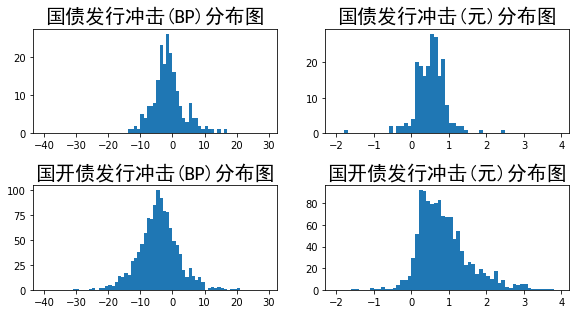

In [4]:
# 绘制国债与国开债地发行冲击分布图（分别以bp和元表示价格冲击）
fig, axes = plt.subplots(2, 2, figsize=(9.6, 4.8))
fig.subplots_adjust(hspace=0.5)
i = 0
for bondtype in ["00", "02"]:
    j = 0
    for column in ["delta", "dprice"]:         
        sql = r"select {0} from tb_sec_delta where seq = 0 and {0} is not null and code0 regexp '[:alnum:]{{2}}{1}.*'".format(column, bondtype)
        imp = np.array(Data(sql, cur).select_col(0))
        if column == "delta":
            if bondtype == "00":
                bins = np.arange(-40, 30, 1)
                title = "国债发行冲击(BP)分布图"
            elif bondtype == "02":
                bins = np.arange(-40, 30, 1)
                title = "国开债发行冲击(BP)分布图"
            else:
                raise ValueError("错误的参数值bondtype")
        elif column == "dprice":
            if bondtype == "02":
                bins = np.arange(-2, 4, 0.1)
                title = "国开债发行冲击(元)分布图"
            elif bondtype == "00":                
                bins = np.arange(-2, 4, 0.1)
                title = "国债发行冲击(元)分布图"
            else:
                raise ValueError("错误的参数值bondtype")
        else:
            raise ValueError("错误的参数值column")
        axes[i, j].hist(imp, bins=bins)
        axes[i, j].set_title(title, fontproperties="SimHei", fontsize=20)
        j += 1
    i += 1

In [5]:
 def get_avg_std_by_term(cur, terms, bond_type=None, column="delta"):
        """计算不同期限的发行冲击的均值与标准差"""
        res = []
        if bond_type is None:
            sql = "select count(*), avg({0}), stddev_samp({0}) from tb_sec_delta where seq = 0 and term = %s".format(column)
        else:
            sql = """select count(*), avg({0}), stddev_samp({0}) from tb_sec_delta where seq = 0 and term = %s 
            and code regexp '[:alnum:]{{2}}{1}.*' and dt > '2016-4-1'""".format(column, bond_type)
        for t in terms:
            num, avg, std = Data(sql, cur, (t,)).data[0]
            res.append([num, avg, std])
        return res

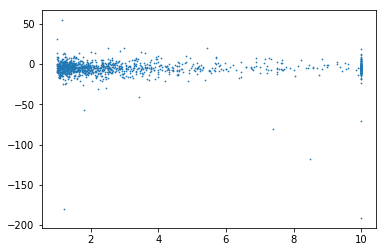

In [6]:
# 绘制债券发行乘数与发行冲击的散点图
sql = r"""select t1.mg_multiplier, t2.delta from tb_pri t1 
inner join tb_sec_delta t2 on t1.code = t2.code and t2.seq = 0
where bond_type = '国开债'"""
data = Data(sql, cur)
x = np.array(data.select_col(0))
y = np.array(data.select_col(1))
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.5)

In [74]:
# 债市周期与发行冲击

bondtype = "02"  # 债券种类：国开债（02） or 国债（00）

dts = [dtt.date(2013, 6, 20), dtt.date(2013, 11, 20), dtt.date(2014, 11, 11), dtt.date(2015, 7, 2), dtt.date(2016, 1, 13), 
       dtt.date(2016, 10, 28), dtt.date(2018, 1, 19), dtt.date(2018, 8, 3)]     # 牛熊分界点（粗略估计）

sql = """select avg(delta), stddev_samp(delta), count(*) from tb_sec_delta
where seq = 0 and dt > %s and dt <= %s and code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)

res = []
for i in range(len(dts)-1):
    data = Data(sql, cur, (dts[i], dts[i+1])).data
    res.append(data[0])

In [8]:
# 债市周期、债券期限与发行冲击

bondtype = "00"
terms = [1, 2, 3, 5, 7, 10]
dts = [dtt.date(2013, 6, 20), dtt.date(2013, 11, 20), dtt.date(2014, 11, 11), dtt.date(2015, 7, 2), dtt.date(2016, 1, 13), 
       dtt.date(2016, 10, 28), dtt.date(2018, 1, 19), dtt.date(2018, 8, 3)]     # 牛熊分界点（粗略估计）


sql1 = """select avg(delta), count(*) from tb_sec_delta 
where seq = 0 and dt > %s and dt <= %s and code regexp '[:alnum:]{{2}}{}.*'
and term = %s""".format(bondtype)

res = []

for i in range(len(dts)-1):
    r = []
    for t in terms:
        d = Data(sql1, cur, (dts[i], dts[i+1], t)).data[0]
        r.append(d)
    res.append(r)   

In [10]:
for r1 in res:
    print()
    for r2 in r1:
        print()
        for r3 in r2:
            print(r3, end="  ")



None  0  
None  0  
4.46999979  1  
10.85999966  1  
5.88666677  3  
4.37000002  3  

None  0  
None  0  
-0.48666668  3  
-7.97000011  3  
-3.44714281  7  
-5.33499994  6  

None  0  
None  0  
-4.14500004  2  
-1.26333332  3  
-0.48499999  6  
-2.05599998  5  

None  0  
10.06000042  1  
-3.46749997  4  
-2.41750002  4  
-2.07999998  4  
-2.01799998  5  

-0.85833335  6  
-0.95333335  3  
-5.03833329  6  
-4.37999989  6  
0.80000003  7  
-1.23499997  6  

3.50199997  10  
0.53750002  4  
-0.99799999  10  
-0.83500003  10  
-1.73222223  9  
-1.75800004  10  

-1.56999999  4  
-0.80499998  2  
-3.88000002  5  
-4.03249994  4  
-3.67833333  6  
-4.36500007  4  

In [58]:
# 发行规模与发行冲击

bondtype = "00"  # 债券种类：国开债（02） or 国债（00）

# 将发行规模五等分，分位数存储于per_amount
sql1 = """select t1.amount, t2.delta from appendix1 t1 inner join tb_sec_delta t2 
on t1.code = t2.code and t2.seq = 0
where t1.code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)
data = Data(sql1, cur).data
data = np.array(data)
data = pd.DataFrame(data, columns=['amount', 'delta'])
per_amount = [0]
for p in range(20, 120, 20):
    per_amount.append(float(np.percentile(data["amount"], p)))
    
# 计算每个分位之间的delta均值
res = []
sql2 = """select avg(t2.delta), count(*) from  appendix1 t1 inner join tb_sec_delta t2 
on t1.code = t2.code and t2.seq = 0
where t1.amount > %s and t1.amount <= %s and t1.code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)
for i in range(len(per_amount)-1):
    d = Data(sql2, cur, (per_amount[i], per_amount[i+1])).data
    res.append(d[0])

(5.76249998, 2.9094022069519125, 297.375004, 8)
(-4.28999998, 5.13443926849149, 280.526316, 19)
(-1.579375, 4.8458979492761065, 264.312502, 16)
(-1.77166663, 3.4902693185494824, 283.388889, 18)
(-1.36368418, 5.090139591783868, 310.507894, 38)
(0.14448273, 4.741611669466564, 293.715517, 58)
(-3.10928572, 3.4017739653009267, 321.075, 28)


In [45]:
class ImpFuture(object):
    """用于统计发行冲击后的国债期货表现"""
    def __init__(self, cur, db):
        self.cur = cur
        self.db = db

    def imp_days(self, bond_type, future_type):
        """将发行冲击五等分，计算之后4日的国债期货收益均值，参数bond_type为续发债类型，分别为
        国债和国开债，future_type为国债期货合约类型("TF"或者"T")"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_term")
        sql1 = """select t1.delta, t2.dsrate, t3.dsrate, t4.dsrate, t5.dsrate
        from impact t1 inner join future_delta t2 inner join future_delta t3
        inner join future_delta t4 inner join future_delta t5
        on t1.dt = t2.dt and t3.seq = t2.seq + 1 and t4.seq = t3.seq+1 and t5.seq = t4.seq+1
        and t3.term = t2.term and t4.term = t3.term and t5.term = t4.term
        and t1.bondtype = %s and t2.term = %s
        order by t1.delta
        """
        data = Data(sql1, self.cur, (bond_type, future_term)).data
        data = pd.DataFrame(np.array(data), columns=["delta", "first", "second", "third", "fourth"])
        # 依据delta将data五等分
        n = 5
        res = []
        l = int(len(data)/n)
        for i in range(n):
            a = i*l
            b = (i+1)*l-1
            if i == 4:
                b = -1
            d = list(data[a:b].mean())
            d.insert(1, len(data[a:b]))
            res.append(d)
        return res

    def imp_minutes(self, bond_type, future_type, day=0):
        """计算发行冲击当日的五分钟级的市场走势"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_type")
        # 获得delta五等分点
        sql1 = """select t1.delta from impact t1 inner join future_minute t2
                  on t1.dt = date(t2.dtt) and t2.seq=0
                  where t1.bondtype = %s and t2.term = %s
                  """
        delta = np.array(Data(sql1, self.cur, (bond_type, future_term)).data)
        delta = pd.DataFrame(delta, columns=["delta"]).dropna()
        per_delta = [float(delta.min()-1)]
        for p in range(20, 120, 20):
            per_delta.append(float(np.percentile(delta, p)))
        # 根据五等分点（per_delta)从数据库中选出每个分位的
        data = []
        if day == 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2
            on t1.dt = date(t2.dtt) and t1.bondtype = %s and t2.term = %s 
            and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')"""
        elif day > 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq +{} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(day)
        else:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq - {} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(abs(day))
        for i in range(len(per_delta)-1):
            a = per_delta[i]
            b = per_delta[i+1]
            da = Data(sql2, self.cur, (bond_type, future_term, a, b))
            time_index = da.select_col(0)
            rate = da.select_col(1)
            data.append(rate)
        data = np.array(data).T
        res = []
        for k in range(1, len(data), 1):
            res.append(100*(data[k] - data[0]))
        res = pd.DataFrame(res, index=time_index[1:], columns=["一", "二", "三", "四", "五"])
        return res

    def imp_minutes_plot(self, day=0):
        """将利率债发行对国债期货市场的影响可视化，即分别以国债-TF、国债-T、国开债-TF、国开债-T作为参数
        计算imp_minutes，并将结果放入一张4×1的图中"""
        imp_minutes_params = [("国债", "TF"), ("国债", "T"), ("国开债", "TF"), ("国开债", "T")]
        fig, axes = plt.subplots(4, 1, figsize=(8,12), sharex="all", )
        xmajorLocator = MultipleLocator(4)
        for params, ax in zip(imp_minutes_params, axes):
            data =  self.imp_minutes(*params, day)
            ax.spines["top"].set_color("none")
            ax.spines["right"].set_color("none")
            ax.xaxis.set_ticks_position("bottom")
            ax.yaxis.set_ticks_position("left")
            labels = ["一", "二", "三", "四", "五"]
            for i in range(len(labels)):
                ax.plot(data.index, data.iloc[:, i], label=labels[i])
            ax.spines["bottom"].set_position(('data', 0))
            ax.xaxis.set_major_locator(xmajorLocator)
            ax.set_title("{}-{}".format(*params))
            ax.legend(loc="best")
        fig.show()
    
    def imp_days_minutes(self, day1, day2, future_type, bond_type="国债", delta_type="delta", k=5, p2r_mode=0):
        """计算发行前day1日至发行后day2日的国债期货五分钟行情序列，k为等分数，默认为5等分"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_type")
        dt0 = dtt.date(2016, 2, 15)
        dt1 = dt0 + dtt.timedelta(days=day1)
        sdt = dt1.strftime("%Y-%m-%d")
        sql1 = """
        select t1.dt, t1.term, t1.{0}, t2.dt, t3.dt, t1.bondtype
        from impact t1 inner join dts1 t2 inner join dts1 t3 inner join dts1 t4
        on t1.dt = t4.dt and t2.seq = t4.seq - %s and t3.seq = t4.seq + %s and t1.bondtype = "{1}"
        where t1.{0} is not null and t1.dt >= '{2}'
        order by t1.{0}
        """.format(delta_type, bond_type, sdt)
        data1 = Data(sql1, self.cur, (day1, day2)).data
        num = len(data1)  # 提取记录的个数，用于
        print(num)
        # 提取交易行情序列
        data2 = []
        sql2 = """
        select close from future_minute
        where date(dtt) between %s and %s and term = {}
        """.format(future_term)
        for d1 in data1:
            d2 = Data(sql2, self.cur, (d1[3], d1[4])).select_col(0)
            d2 = p2r(d2, mode=p2r_mode)
            data2.append(d2)
        n = round(num / k)  # 每个分位的记录个数
        res = []  # 结果res用于保存
        for i in range(k):
            a = i * n
            if i == k - 1:
                b = num
            else:
                b = n * (i + 1)
            r = np.mean(data2[a:b], axis=0)
            res.append(r)
        return res

In [46]:
def p2r(price, mode=0):
    """将价格时间序列转换为收益率序列，默认为以初始值为基准，当mode为0时返回原价格序列，若为1则返回涨跌幅"""
    if mode == 0:
        res = price
    elif mode == 1:
        p0 = price[0]  # 初始价格
        res = [100 * (p - p0) / p0 for p in price]
    return res


def trading_time(dt, minute_delta=5):
    """生成交易日的交易时间序列，minute_delta是时间间隔，默认为5分钟"""
    res = []
    dt_time0 = dtt.datetime(dt.year, dt.month, dt.day, 9, 20, 0)
    dt_time1 = dtt.datetime(dt.year, dt.month, dt.day, 11, 30, 0)
    dt_time2 = dtt.datetime(dt.year, dt.month, dt.day, 13, 5, 0)
    dt_time3 = dtt.datetime(dt.year, dt.month, dt.day, 15, 15, 0)
    dt_times_am = []
    dt_times_pm = []
    dt_time = dt_time0
    while dt_time <= dt_time1:
        dt_times_am.append(dt_time)
        dt_time += dtt.timedelta(minutes=minute_delta)
    res.extend(dt_times_am)
    dt_time = dt_time2
    while dt_time <= dt_time3:
        dt_times_pm.append(dt_time)
        dt_time += dtt.timedelta(minutes=minute_delta)
    res.extend(dt_times_pm)
    return res

In [60]:
day1 = 5
day2 = 5
k = 5
dt0 = dtt.date(2016, 2, 15)
times = trading_time(dt0)
strtimes = [time.strftime("%H:%M") for time in times]
days = []
days1 = ["T-{}".format(day) for day in range(day1, 0, -1)]
days2 = ["T+{}".format(day) for day in range(0, day2+1)]
days.extend(days1)
days.extend(days2)
index = []
for day in days:
    for time in strtimes:
        if time == "11:30":
            index.append("{}_{}/{}".format(day, time, "13:00"))
        else:
            index.append("{}_{}".format(day, time))
columns0 = ["一", "二", "三", "四", "五", "六", "七"]
columns = columns0[0: k]

In [62]:
imp_future = ImpFuture(cur, db)
data1 = imp_future.imp_days_minutes(day1, day2, "T", k=k, p2r_mode=0, delta_type="delta")
data2 = imp_future.imp_days_minutes(day1, day2, "T", k=k, p2r_mode=1, delta_type="delta")
pd_data1 = pd.DataFrame(list(zip(*data1)), index=index, columns=columns)
pd_data2 = pd.DataFrame(list(zip(*data2)), index=index, columns=columns)

140
140


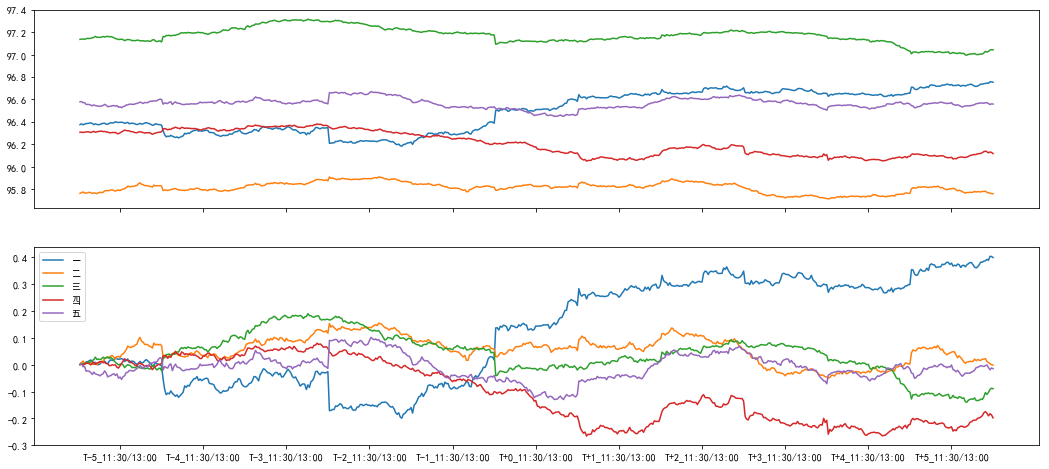

In [63]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
locator = ticker.FixedLocator([54*d+26 for d in range(day1+day2+1)])
# formatter = ticker.StrMethodFormatter("{.3}")
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex="all")
for ax, pd_data in zip(axes, [pd_data1, pd_data2]):
    labels = pd_data.columns
    for i in range(len(labels)):
        ax.plot(pd_data.index, pd_data.iloc[:, i], label=labels[i])
ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)
ax.legend(loc="best")

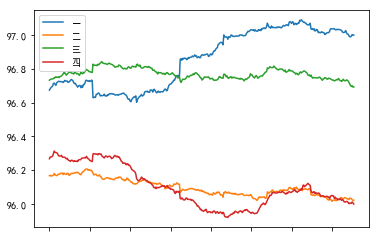

In [38]:
pd_data1.plot()

In [35]:
formatter = ticker.StrMethodFormatter("{.3}")

In [29]:
class BondYTM(object):
    """本类用于计算续发固定利率附息国债到期收益率"""

    def __init__(self, term, rate, dt0: dtt.date, freq = 1, par=100):
        """类初始化函数，terms代表债券年限，rate表示发行利率，dt0表示发行日期，par表示债券面值，默认100，付息频率支持
        1年1次或1年2次"""
        self.term = term
        self.rate = rate / 100
        self.dt0 = dt0
        self.year0 = self.dt0.year
        self.month0 = self.dt0.month
        self.day0 = self.dt0.day
        self.par = par
        self.freq = freq

    def get_ts(self, dt: dtt.date):
        """本方法用于计算利息与本金支付的时间点序列，本金在最后一个时间点支付，例如一个已经发行1.75年的5年期付息国债，
        本方法分别返回一个0.25的数值和一个[0, 1, 2, 3]的列表，0.25表示距离最近的一次付息时间长度（年），[0, 1, 2, 3]
        接下来剩四次付息，距离这四次付息时间点的时间分别为0.25，1.25、2.25和3.25（年），拥有这两个结果便可以根据价格
        计算到期收益率，或者根据到期收益率计算价格"""
        if self.freq == 1:
            # 年付息次数为1次时的计算相对简单
            if dt > dtt.date(dt.year, self.month0, self.day0) or dt == self.dt0:
                x = dt.year - self.year0
                y = (dtt.date(dt.year+1, self.month0, self.day0) - dt).days + 1
                year_days = (dtt.date(dt.year+1, self.month0, self.day0) - dtt.date(dt.year, self.month0, self.day0)).days
            else:
                x = dt.year - self.year0 - 1
                y = (dtt.date(dt.year, self.month0, self.day0) - dt).days + 1
                year_days = (dtt.date(dt.year, self.month0, self.day0) - dtt.date(dt.year - 1, self.month0, self.day0)).days
            t0 = y / year_days
            ts = [i for i in range(int(self.term) - x)]
        elif self.freq == 2:
            # 年付息次数为2次时的计算相对复杂一些，需要先计算出除了发行日次日的付息日外的另一个付息日（实际为发行日后的六个月）
            year1 = dt.year
            dt0 = dtt.date(dt.year, self.month0, self.day0)
            if self.month0 <= 6:
                month1 = self.month0 + 6
                try:
                    dt1 = dtt.date(year1, month1, self.day0)
                except ValueError as e:
                    dt1 = dtt.date(year1, month1+1, 1) - dtt.timedelta(1)
                if dt0 < dt <= dt1 or dt == self.dt0:
                    x = 2 * (dt.year - self.year0)
                    y = (dt1 - dt).days + 1
                    half_year_days = (dt1 - dt0).days
                elif dt <= dt0:
                    x = 2 * (dt.year - self.year0) - 1
                    y = (dtt.date(dt.year, self.month0, self.day0) - dt).days + 1
                    half_year_days = (dt0 - dtt.date(dt1.year -1, dt1.month, dt1.day)).days
                else:
                    dt2 = dtt.date(dt.year + 1, self.month0, self.day0)
                    x = 2 * (dt.year - self.year0) + 1
                    y = (dt2 - dt).days + 1
                    half_year_days = (dt2 - dt1).days
                t0 = y / half_year_days
                ts = [i for i in range(int(2 * self.term) - x)]
            else:
                month1 = self.month0 - 6
                try:
                    dt1 = dtt.date(year1, month1, self.day0)
                except ValueError as e:
                    dt1 = dtt.date(year1, month1+1, 1) - dtt.timedelta(1)
                if dt1 < dt <= dt0 or dt == self.dt0:
                    x = 2 * (dt.year - self.year0) - 1
                    y = (dt0 - dt).days + 1
                    half_year_days = (dt0 - dt1).days
                elif dt <= dt1:
                    dt2 = dtt.date(dt.year - 1, self.month0, self.day0)
                    x = 2 * (dt.year - self.year0) - 2
                    y = (dt1 - dt).days + 1
                    half_year_days = (dt1 - dt2).days
                else:
                    dt2 = dtt.date(dt.year+1, dt1.month, dt1.day)
                    x = 2 * (dt.year - self.year0)
                    y = (dt2 - dt).days + 1
                    half_year_days = (dt2 - dt0).days
                t0 = y / half_year_days
                ts = [i for i in range(int(2 * self.term) - x)]
        else:
            raise ValueError("不被接受的参数值self.freq")
        return t0, ts

    def bond_ytm(self, dt: dtt.date, price, mode=0, guess=0.03):
        """根据价格计算到期收益率，当mode=0时，不足1年的现金流仍以复利形式计算，当mode=1时，不足1年的现金流以单利按天数计算"""
        t0, ts = self.get_ts(dt)
        coup = self.par * self.rate/self.freq
        if mode == 0:
            ytm_func = lambda y: (sum([coup / (1 + y) ** t for t in ts]) + self.par / (1 + y) ** ts[-1]) / (
                        1 + y) ** t0 - price
            fprime = lambda y: sum([-(t + t0) * coup / (1 + y) ** (t + t0 + 1) for t in ts]) - (
                ts[-1] + t0) * self.par / (1 + y) ** (ts[-1] + t0 + 1)
        elif mode ==1:
            ytm_func = lambda y: (sum([coup / (1 + y) ** t for t in ts]) + self.par / (1 + y) ** ts[-1]) / (
                    1 + t0 * y) - price
            fprime = lambda y: (sum([-t * coup / (1 + y) ** (t + 1) for t in ts]) - ts[-1] * self.par / (1 + y) ** (
                    ts[-1] + 1)) / (1 + t0 * y) - t0 * (1 + t0 * y) ** (-2) * (
                                       sum([coup / (1 + y) ** t for t in ts]) + self.par / (1 + y) ** ts[-1])
        else:
            raise ValueError("不被接受的参数值mode")
        return self.freq * 100 * optimize.newton(ytm_func, guess, fprime=fprime)

    def bond_price(self, dt: dtt.date, rate, mode=0):
        """根据到期收益率计算价格，参数中dt表示增发债日期，rate表示到期收益率"""
        rate = rate / (100 * self.freq)
        coup = self.par * self.rate / self.freq
        t0, ts = self.get_ts(dt)
        if mode == 0:
            price = (sum([coup / (1 + rate) ** t for t in ts]) + self.par / (1 + rate) ** ts[-1])/(1 + rate) ** t0
        elif mode == 1:
            price = (sum([coup / (1 + rate) ** t for t in ts]) + self.par / (1 + rate) ** ts[-1])/(1 + t0 * rate)
        else:
            raise ValueError("不被接受的参数值mode")
        return price


In [30]:
bond = BondYTM(2, 3.62, dtt.date(2017, 6, 14), 1)

In [32]:
bond.bond_price(dtt.date(2017, 8, 10), 3.4537)

100.84007826389151